In [2]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import GCRCatalogs
import healpy
import pickle,sys
import mysql
from mysql.connector import Error
import clmm
from clmm.dataops import compute_galaxy_weights
from clmm import Cosmology
from scipy.integrate import simps
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
conn = mysql.connector.connect(host='ccqserv201', user='qsmaster', port=30040)
cursor = conn.cursor(dictionary=True, buffered=True)

In [3]:
sys.path.append('../lensing_profile_measurement')
import _utils_lensing_profiles

In [5]:
import _utils_photometric_redshifts
import _utils_extract_sources_in_cosmoDC2
import _config_lensing_profiles
from astropy.table import QTable, Table, vstack, join, hstack

['DSt_true', 'DSx_true', 'W_l_true', 'radius_true', 'DSt_flex', 'DSx_flex', 'W_l_flex', 'radius_flex', 'DSt_bpz', 'DSx_bpz', 'W_l_bpz', 'radius_bpz']


## Cosmodc2 with qserv & GCRCatalogs

In [6]:
def qserv_query(ra, dec, rmax = 10):
    r"""
    quantities wanted + cuts
    Attributes:
    -----------
    z: float
        lens redshift
    ra: float
        lens right ascension
    dec: float
        lens declinaison
    rmax: float
        maximum radius
    """
    zmax = 3.
    zmin = 0
    theta_max = (rmax/lens_distance) * (180./np.pi)
    query = "SELECT data.coord_ra as ra, data.coord_dec as dec, data.redshift as z, "
    query += "data.galaxy_id as galaxy_id, "
    query += "data.mag_i, data.mag_r, data.mag_y, "
    query += "data.shear_1 as shear1, data.shear_2 as shear2, data.convergence as kappa, "
    query += "data.ellipticity_1_true as e1_true_uncorr, data.ellipticity_2_true as e2_true_uncorr " 
    query += "FROM cosmoDC2_v1_1_4_image.data as data "
    query += f"WHERE data.redshift >= {zmin} AND data.redshift < {zmax} "
    query += f"AND scisql_s2PtInCircle(coord_ra, coord_dec, {ra}, {dec}, {theta_max}) = 1 "
    query += f"AND data.mag_i <= 25 "
    query += ";" 
    return query

In [13]:
#cluster
lens_cat = np.load('../data/lens_catalog_cosmoDC2_v1.1.4_redmapper_v0.8.1.pkl', allow_pickle = True)
mask = (lens_cat['richness'] > 20)&(lens_cat['redshift'] > .2)
index = 4000
z, ra, dec, richness = 0.01, lens_cat['ra'][mask][index], lens_cat['dec'][mask][index], lens_cat['richness'][mask][index]

In [14]:
z, ra, dec, richness

(0.01, 72.62527257555823, -40.311777764790264, 21.239138)

### true shapes, true redshifts

In [17]:
lens_distance=cosmo.eval_da(z)
bckgd_galaxy_catalog_truth=_utils_extract_sources_in_cosmoDC2.extract(qserv_query = qserv_query( ra, dec, rmax = .2),
                                        conn_qserv=conn, cosmo=cosmo)

In [18]:
len(bckgd_galaxy_catalog_truth)

34949

In [19]:
gc_bpz  = "cosmoDC2_v1.1.4_image_with_photozs_v1"
gc_flex = "cosmoDC2_v1.1.4_image_with_photozs_flexzboost_v1"
healpix_dc2 = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_image").get_catalog_info()['healpix_pixels']
z_bins  = GCRCatalogs.load_catalog(gc_flex).photoz_pdf_bin_centers
z_bins[0] = 1e-7
photoz_gc=[gc_bpz, gc_flex]
photoz_label=['_bpz', '_flex']

In [20]:
def query_photoz():
    return ['photoz_pdf', 'photoz_mean','photoz_mode','photoz_odds','galaxy_id']

In [21]:
#extract photometric redshifts with GCRCatalogs
print('extracting photoz redshift infos (GCRCatalogs)')
id_gal=bckgd_galaxy_catalog_truth['galaxy_id']
ras=bckgd_galaxy_catalog_truth['ra']
decs=bckgd_galaxy_catalog_truth['dec']
#find all different healpix pixels
healpix = np.array(np.unique(healpy.ang2pix(32, ras, decs, nest=False, lonlat=True)))
print(healpix)
table_photoz = Table()
table_photoz['galaxy_id'] = id_gal
for k, gc_ in enumerate(photoz_gc):
    print(f'----> extraction in {gc_}')
    pz_table = Table(names = ['sigmac_photoz', 'p_background', 'photoz_dispersion', 
                          'sigmac_estimate_0', 'sigmac_estimate_1', 'sigmac_estimate_2', 
                          'z_estimate_0', 'z_estimate_1', 'z_estimate_2', 
                          'galaxy_id', 'photoz_mean', 'photoz_mode', 'photoz_odds'])
    photoz_gc_ = GCRCatalogs.load_catalog(gc_)
    for i, hp in enumerate(healpix):
        #browse healpix pixels
        print(f'-----> heapix pixel = ' + str(hp))
        chunk = photoz_gc_.get_quantities(query_photoz(), native_filters=[f'healpix_pixel=={hp}'], return_iterator=True)
        print(chunk)
        for j in range(3):
            #browse chunk data
            print('chunk = ' + str(j))
            try: 
                dat_extract_photoz_chunk = Table(next(chunk))
            except: 
                print('no chunk')
                continue
            print(f'full healpix = ' + str(len(dat_extract_photoz_chunk['galaxy_id'])))
            #use only selected galaxies
            dat_extract_photoz_chunk_truncated = dat_extract_photoz_chunk[np.isin(dat_extract_photoz_chunk['galaxy_id'],
                                                                                  table_photoz['galaxy_id'])]
           # if len(dat_extract_photoz_chunk_truncated['galaxy_id']) == 0: continue

            print('truncated healpix = ' + str(len(dat_extract_photoz_chunk_truncated['galaxy_id'])))
            pzbins_table=np.array([z_bins for i in range(len(dat_extract_photoz_chunk_truncated['photoz_pdf'].data))])

            #compute WL weights with 
            pz_quantities_chunk = _utils_photometric_redshifts.compute_photoz_quantities(z, dat_extract_photoz_chunk_truncated['photoz_pdf'], 
                                                                   pzbins_table, n_samples_per_pdf=3, cosmo=cosmo,
                                                                   use_clmm=False)
            pz_quantities_chunk['galaxy_id'] = dat_extract_photoz_chunk_truncated['galaxy_id']
            pz_quantities_chunk['photoz_mean'] = dat_extract_photoz_chunk_truncated['photoz_mean']
            pz_quantities_chunk['photoz_mode'] = dat_extract_photoz_chunk_truncated['photoz_mode']
            pz_quantities_chunk['photoz_odds'] = dat_extract_photoz_chunk_truncated['photoz_odds']
            pz_table = vstack([pz_table, pz_quantities_chunk])
    colnames = pz_table.colnames
    for name in colnames:
        if name!='galaxy_id':
            pz_table.rename_column(name, name + photoz_label[k])
    bckgd_galaxy_catalog_truth = join(Table(bckgd_galaxy_catalog_truth), pz_table, keys='galaxy_id')

extracting photoz redshift infos (GCRCatalogs)
[10074]
----> extraction in cosmoDC2_v1.1.4_image_with_photozs_v1
-----> heapix pixel = 10074
<generator object BaseGenericCatalog._get_quantities_iter at 0x7f2c9017f610>
chunk = 0
full healpix = 832748
truncated healpix = 24974


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


chunk = 1
full healpix = 600251
truncated healpix = 9277


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


chunk = 2
full healpix = 138089
truncated healpix = 698
----> extraction in cosmoDC2_v1.1.4_image_with_photozs_flexzboost_v1


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


-----> heapix pixel = 10074
<generator object BaseGenericCatalog._get_quantities_iter at 0x7f2c900ab5a0>
chunk = 0
full healpix = 832748
truncated healpix = 24974


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.
/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


chunk = 1
full healpix = 600251
truncated healpix = 9277


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


chunk = 2
full healpix = 138089
truncated healpix = 698


/pbs/home/c/cpayerne/.conda/envs/myenv/lib/python3.10/site-packages/clmm-1.10.0-py3.10.egg/clmm/cosmology/parent_class.py:454: UserWarning: 
Some source redshifts are lower than the cluster redshift.
Sigma_crit = np.inf for those galaxies.


In [24]:
mask_mag= bckgd_galaxy_catalog_truth['mag_i'] < 24.5
mask_mag*= bckgd_galaxy_catalog_truth['mag_r'] < 28
bckgd_galaxy_catalog = bckgd_galaxy_catalog_truth[mask_mag]

In [25]:
ellipticity_uncorr_e1 = bckgd_galaxy_catalog['e1_true']
ellipticity_uncorr_e2 = bckgd_galaxy_catalog['e2_true']
ellipticity_corr_e1, ellipticity_corr_e2 = _utils_extract_sources_in_cosmoDC2.correct_shear_ellipticity(ellipticity_uncorr_e1, ellipticity_uncorr_e2)

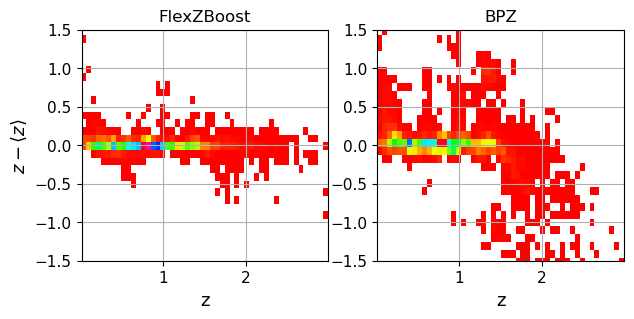

In [76]:
plt.figure(figsize=(7,3))
plt.subplot(121)
plt.title('FlexZBoost')
plt.hist2d(bckgd_galaxy_catalog['z'], bckgd_galaxy_catalog['photoz_mean_flex']- bckgd_galaxy_catalog['z'], cmap='hsv', bins=50, cmin=1)
plt.grid(True)
plt.ylim(-1.5, 1.5)
plt.ylabel(r'$z - \langle z\rangle$', fontsize=13)
plt.xlabel('z', fontsize=13)
plt.tick_params(axis='both', which = 'both', labelsize= 11)
plt.subplot(122)
plt.title('BPZ')
plt.hist2d(bckgd_galaxy_catalog['z'], bckgd_galaxy_catalog['photoz_mean_bpz']- bckgd_galaxy_catalog['z'], cmap='hsv', bins=50, cmin=1)
plt.grid(True)
plt.ylim(-1.5, 1.5)
plt.xlabel('z', fontsize=13)
plt.tick_params(axis='both', which = 'both', labelsize= 11)
plt.savefig(f'../fig/PZ_on_cosmoDC2.png', bbox_inches='tight', dpi=100)